[View in Colaboratory](https://colab.research.google.com/github/amohamdy/Sentiment-analysis/blob/master/Keras_.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


**Make Current Directory**

In [0]:
import os
os.chdir("drive/My Drive/sentiment-model/Keras")

In [3]:
!ls

Keras .ipynb  tweets-pos-neg.csv


**Download and unzip ngrok**

In [4]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


Redirecting output to ‘wget-log’.
Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


**Run Tensor Board**

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

**Run ngrok**

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

**Get URL**
Run the next cell to start the training before open the url.

In [7]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://87d7761a.ngrok.io


In [8]:
import os   # iterate throw DIRECTORIES 
import numpy as np
import pandas as pd
import tensorflow as tf
from nltk.tokenize import word_tokenize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import  LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense,Activation
from keras.layers import Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint
#from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
#import keras.utils
#from keras import utils as np_utils
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import re
import string
import collections
import time
import pickle
seed = 7
np.random.seed(seed)
from sklearn.utils.multiclass import type_of_target

Using TensorFlow backend.


**Load CSV File**

In [0]:
#Read CSV Files 
df=pd.read_csv('tweets-pos-neg.csv', usecols = ['text','airline_sentiment'])
df = df.reindex(['text','airline_sentiment'], axis=1) #reorder columns
df=df.apply(lambda x: x.astype(str).str.lower()) #convert data to lower case

**Normalization Process**

In [0]:
def normalize(text):
    text= re.sub(r"http\S+", r'', text) #replaces links with "URL" or space
    text= re.sub(r"@\S+", r'', text) #replaces @Mention with "mention" or space
    punctuation = re.compile(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~|0-9]')
    text = re.sub(punctuation, ' ', text)
    text= re.sub(r'(.)\1\1+', r'\1', text)  #solve el.ongation problem ex loooool=>lol, lool=>lool  
    return text

In [0]:
def prepareDataSets(df):
    sentences=[]
    for index, r in df.iterrows():
        text= normalize(r['text'])
#         if r['airline_sentiment']=='positive':
#             sentences.append([text,1])
#         else:
#             sentences.append([text,0])
#         #text= stopWordRemove(text)
        sentences.append([text,r['airline_sentiment']])
        df_sentences=pd.DataFrame(sentences,columns=['text','airline_sentiment'])
    return df_sentences

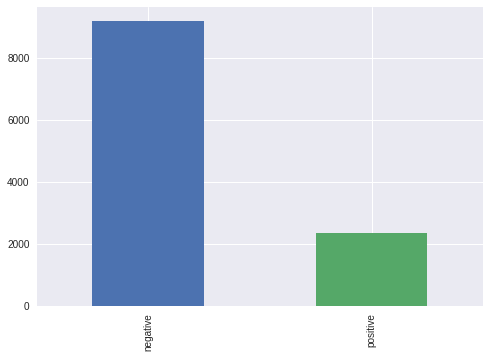

In [12]:
edit_df=prepareDataSets(df)
edit_df=shuffle(edit_df)
target=pd.value_counts(edit_df['airline_sentiment'].values)
target.plot.bar()

In [0]:
X=edit_df.iloc[:,0]
Y=edit_df.iloc[:,1]

** Convert reviews to Tokens then Tokens to Integers**

In [0]:

max_features = 50000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
#convert review tokens to integers
X_seq = tokenizer.texts_to_sequences(X)

In [15]:
print('Fitted tokenizer on {} documents'.format(tokenizer.document_count))
print('{} words in dictionary'.format(tokenizer.num_words))
print('Top 5 most common words are:', collections.Counter(tokenizer.word_counts).most_common(5))

Fitted tokenizer on 11541 documents
50000 words in dictionary
Top 5 most common words are: [('to', 6988), ('the', 5085), ('i', 4235), ('a', 3763), ('you', 3403)]


**Get The Length of each Review then get MAX **

In [0]:
def countWords(review):
    counts=[]
    for review in X:
        review_legnth=len(review.split())
        counts.append(review_legnth)
    return counts

In [17]:
counts=countWords(X)
max(counts)

32

In [0]:
# Equal Length of Sequence Padding Sequence according to MAX length of reviews
seq_len=35
X_pad = pad_sequences(X_seq,maxlen=seq_len)

In [0]:
# Encoding Target Value
# convert target value from string to integer
le=LabelEncoder()
Y_le=le.fit_transform(Y)
Y_le_oh=to_categorical(Y_le)
#np.argmax(to_categorical(Y_le))

In [20]:
Y_le_oh

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

**Train, Test split**

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pad,Y_le_oh, test_size = 0.33, random_state = 42)
X_train, X_Val, Y_train, Y_Val = train_test_split(X_train,Y_train, test_size = 0.1, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(X_Val.shape,Y_Val.shape)
type(Y_test)

(6958, 35) (6958, 2)
(3809, 35) (3809, 2)
(774, 35) (774, 2)


numpy.ndarray

**Build CNN Model**

In [22]:
# Create the model
output_dim = 32    #no of vector columns
model_cnn = Sequential()
model_cnn.add(Embedding(max_features, output_dim, input_length=seq_len))
model_cnn.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dense(2, activation='softmax'))
model_cnn.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model_cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 32)            1600000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 34, 100)           6500      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 17, 100)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1700)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               435456    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 2,042,470
Trainable params: 2,042,470
Non-trainable params: 0
_________________________________________________________________


In [0]:
Name="Sentimnt-Analysis-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir='./log/{}'.format(Name))

In [24]:
batch_size=32
history=model_cnn.fit(X_train, Y_train, epochs=3, batch_size=batch_size, callbacks=[tensorboard], validation_data=(X_Val, Y_Val))
scores = model_cnn.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[-1]*100))

Train on 6958 samples, validate on 774 samples
Epoch 1/3
6958/6958 [==============================] - 3s 495us/step - loss: 0.3462 - acc: 0.8505 - val_loss: 0.2393 - val_acc: 0.9031
Epoch 2/3
6958/6958 [==============================] - 2s 313us/step - loss: 0.1271 - acc: 0.9524 - val_loss: 0.2567 - val_acc: 0.9057
Epoch 3/3
6958/6958 [==============================] - 2s 320us/step - loss: 0.0452 - acc: 0.9855 - val_loss: 0.3079 - val_acc: 0.9109
Accuracy: 91.60%


**Evaluate Model**

In [0]:
def cnn_evaluate(): 
    # predict class with test set
    Y_predict =  model_cnn.predict_classes(X_test, batch_size=batch_size, verbose=0)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(Y_test,axis=1),Y_predict)*100))
    
    #classification report
    print('\n')
    print(classification_report(np.argmax(Y_test,axis=1), Y_predict))
    #confusion matrix
    confmat = confusion_matrix(np.argmax(Y_test,axis=1), Y_predict)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

Accuracy:	91.6%


             precision    recall  f1-score   support

          0       0.94      0.96      0.95      3057
          1       0.81      0.75      0.78       752

avg / total       0.91      0.92      0.91      3809



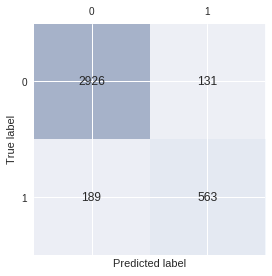

In [26]:
cnn_evaluate()

In [0]:
Y_predict =  model_cnn.predict_classes(X_test, batch_size=batch_size, verbose=0)

#print(type_of_target(Y_test), type_of_target(Y_predict))

In [0]:
model_cnn.save('Keras-Model.h5')

**Save X  in pickle to load automaticaly **

In [0]:
pickle_out=open("X.pickle","wb")
pickle.dump(X_pad,pickle_out)
pickle_out.close()

**Save Y  in pickle to load automaticaly **

In [0]:
pickle_out=open("Y.pickle","wb")
pickle.dump(Y_le_oh,pickle_out)
pickle_out.close()

**Load X**

In [0]:
pickle_in=open("X.pickle","rb")
X_pad=pickle.load(pickle_in)

**Load Y**

In [0]:
pickle_in=open("Y.pickle","rb")
Y_le_oh=pickle.load(pickle_in)